In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target
df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()
x = data[:,:-1]
y = data[:,-1:]

In [16]:
# 데이터 분할
ratio = [.6,.2,.2]
train_cnt = int(data.size(0)*ratio[0])
valid_cnt = int(data.size(0)*ratio[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [17]:
# 데이터 랜덤화
indices = torch.randperm(data.size(0))
x = torch.index_select(x,dim=0,index=indices)
y = torch.index_select(y,dim=0,index=indices)

x = x.split(cnts,dim=0)
y = y.split(cnts,dim=0)

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [19]:
# 데이터 정규화 
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()]

In [22]:
# 학습 코드 구현
model = nn.Sequential(
    nn.Linear(x[0].size(-1),6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
    nn.Sigmoid() # 이진 분류를 위해 추가
)

optimizer = optim.Adam(model.parameters())

# 하이퍼 파라미터
n_epochs = 4000
batch_size = 256
print_interval = 100

from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

train_history, valid_history = [],[]

import time
start = time.time()
for i in range(n_epochs):
    #shuffles
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_,y_): # iteration : 12,384 // 256 + 1 = 49 
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss) # 메모리 손실을 없애기 위해

        # y_hat += [y_hat_i]

    train_loss = train_loss / len(x_)

    with torch.no_grad(): # 계산 그래프 생성을 하지 않음 (forward만 하고 backward는 하지 않음)
        # shuffle 과정 필요 없음
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_,y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_) # 1epoch 당 평균 손실값(검증)

    # 손실곡선을 그리기 위해 손실 값 저장
    train_history += [train_loss] # epoch 마다 학습 솔실 값 차례로 저장
    valid_history += [valid_loss] # epoch 마다 학습 솔실 값 차례로 저장

    # 출력
    if(i+1) % print_interval == 0:
        print('Epoch %d/%d: train_loss=%.4f valid_loss=%.4f lowest_loss=%.4f elapsed_time=%.2fsec' % (
            (i+1), n_epochs,
            train_loss,
            valid_loss,
            lowest_loss,
            time.time() - start
        ))
        start = time.time()

    # 검증 손실의 최소값 찾기
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict()) # 최소손실일 때 모델을 저장
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('There is no improvement during last %d epochs.' % early_stop)
            break
            
# 학습 종료 후
print('The best validation loss from epoch %d : %.4e' % (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model) # 최소 손실 모델로 복귀

Epoch 100/4000: train_loss=0.0699 valid_loss=0.0695 lowest_loss=0.0716 elapsed_time=0.09sec
Epoch 200/4000: train_loss=0.0171 valid_loss=0.0198 lowest_loss=0.0198 elapsed_time=0.06sec
Epoch 300/4000: train_loss=0.0066 valid_loss=0.0209 lowest_loss=0.0198 elapsed_time=0.05sec
There is no improvement during last 100 epochs.
The best validation loss from epoch 205 : 1.9768e-02


<All keys matched successfully>

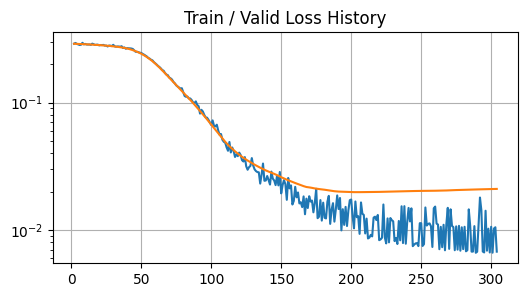

In [25]:
# 손실곡선 확인

plot_from = 2

plt.figure(figsize=(6,3))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

### 다중클래스 분류
- 각 클래스 별 확률 값을 구함
- 정답은 클래스 중 확률 값이 가장 큰 것을 정답으로 간주

## 소프트맥스 함수
- max 함수의 소프트 버전
- 임의의 벡터를 입력받아 이산 확률 분포의 형태로 출력
- 정답이 되는 것은 1에 가깝게 되고 정답이 아닌 것은 0에 가깝게 됨
- 확률 분포이므로 총합은 1
- 비교 : 하드 맥스의 경우라면, 가장 큰 값만 1이 되고 나머지는 0이 됨

## 혼동행렬
- 분휴 문제의 성능평가 -> 정확도
- 실제 서비스를 위해서는 단순한 정확도보다 잘 들리는 케이스를 파악하는 것도 중요함

In [53]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [54]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([transforms.ToTensor()]))

In [55]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

/var/folders/dc/3dqm8vys2qv2c52_q3sn76xr0000gn/T/ipykernel_28914/2513799075.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)


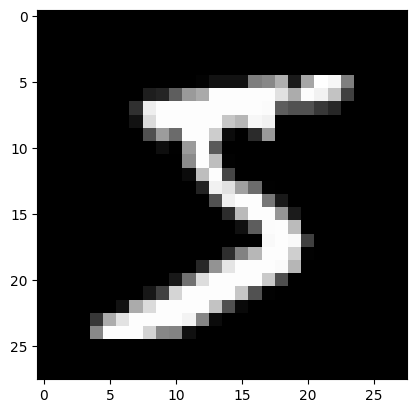

In [56]:
plot(train.data[0])

### 데이터 형태 변경

In [83]:
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [84]:
# 데이터 분할
ratios = [.8,.2]

train_cnt = int(x.size(0)*ratios[0])
valid_cnt = int(x.size(0)*ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

# 데이터 랜덤화
indices = torch.randperm(x.size(0))

x = torch.index_select(x,dim=0,index=indices)
y = torch.index_select(y,dim=0,index=indices)

x = list(x.split(cnts,dim=0))
y = list(y.split(cnts,dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [85]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500,400),
    nn.LeakyReLU(),
    nn.Linear(400,300),
    nn.LeakyReLU(),
    nn.Linear(300,200),
    nn.LeakyReLU(),
    nn.Linear(200,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

### GPU 사용을 위한 코드

In [86]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [87]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [93]:
# 하이퍼 파라미터
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [94]:
train_history, valid_history = [],[]

import time
start = time.time()
for i in range(n_epochs):
    #shuffles
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_,y_): # iteration : 12,384 // 256 + 1 = 49 
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss) # 메모리 손실을 없애기 위해

        # y_hat += [y_hat_i]

    train_loss = train_loss / len(x_)

    with torch.no_grad(): # 계산 그래프 생성을 하지 않음 (forward만 하고 backward는 하지 않음)
        # shuffle 과정 필요 없음
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_,y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_) # 1epoch 당 평균 손실값(검증)

    # 손실곡선을 그리기 위해 손실 값 저장
    train_history += [train_loss] # epoch 마다 학습 솔실 값 차례로 저장
    valid_history += [valid_loss] # epoch 마다 학습 솔실 값 차례로 저장

    # 출력
    if(i+1) % print_interval == 0:
        print('Epoch %d/%d: train_loss=%.4f valid_loss=%.4f lowest_loss=%.4f elapsed_time=%.2fsec' % (
            (i+1), n_epochs,
            train_loss,
            valid_loss,
            lowest_loss,
            time.time() - start
        ))
        start = time.time()

    # 검증 손실의 최소값 찾기
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict()) # 최소손실일 때 모델을 저장
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('There is no improvement during last %d epochs.' % early_stop)
            break
            
# 학습 종료 후
print('The best validation loss from epoch %d : %.4e' % (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model) # 최소 손실 모델로 복귀

Epoch 10/1000: train_loss=0.0111 valid_loss=0.1270 lowest_loss=0.0957 elapsed_time=6.70sec
Epoch 20/1000: train_loss=0.0058 valid_loss=0.1221 lowest_loss=0.0957 elapsed_time=6.73sec
Epoch 30/1000: train_loss=0.0058 valid_loss=0.1350 lowest_loss=0.0957 elapsed_time=6.61sec
Epoch 40/1000: train_loss=0.0080 valid_loss=0.1449 lowest_loss=0.0957 elapsed_time=6.71sec
Epoch 50/1000: train_loss=0.0033 valid_loss=0.1524 lowest_loss=0.0957 elapsed_time=6.73sec
Epoch 60/1000: train_loss=0.0000 valid_loss=0.1747 lowest_loss=0.0957 elapsed_time=6.68sec
Epoch 70/1000: train_loss=0.0000 valid_loss=0.1894 lowest_loss=0.0957 elapsed_time=6.66sec
Epoch 80/1000: train_loss=0.0000 valid_loss=0.2032 lowest_loss=0.0957 elapsed_time=6.70sec
Epoch 90/1000: train_loss=0.0000 valid_loss=0.2171 lowest_loss=0.0957 elapsed_time=6.71sec
Epoch 100/1000: train_loss=0.0000 valid_loss=0.2317 lowest_loss=0.0957 elapsed_time=6.66sec
There is no improvement during last 100 epochs.
The best validation loss from epoch 2 : 9

<All keys matched successfully>

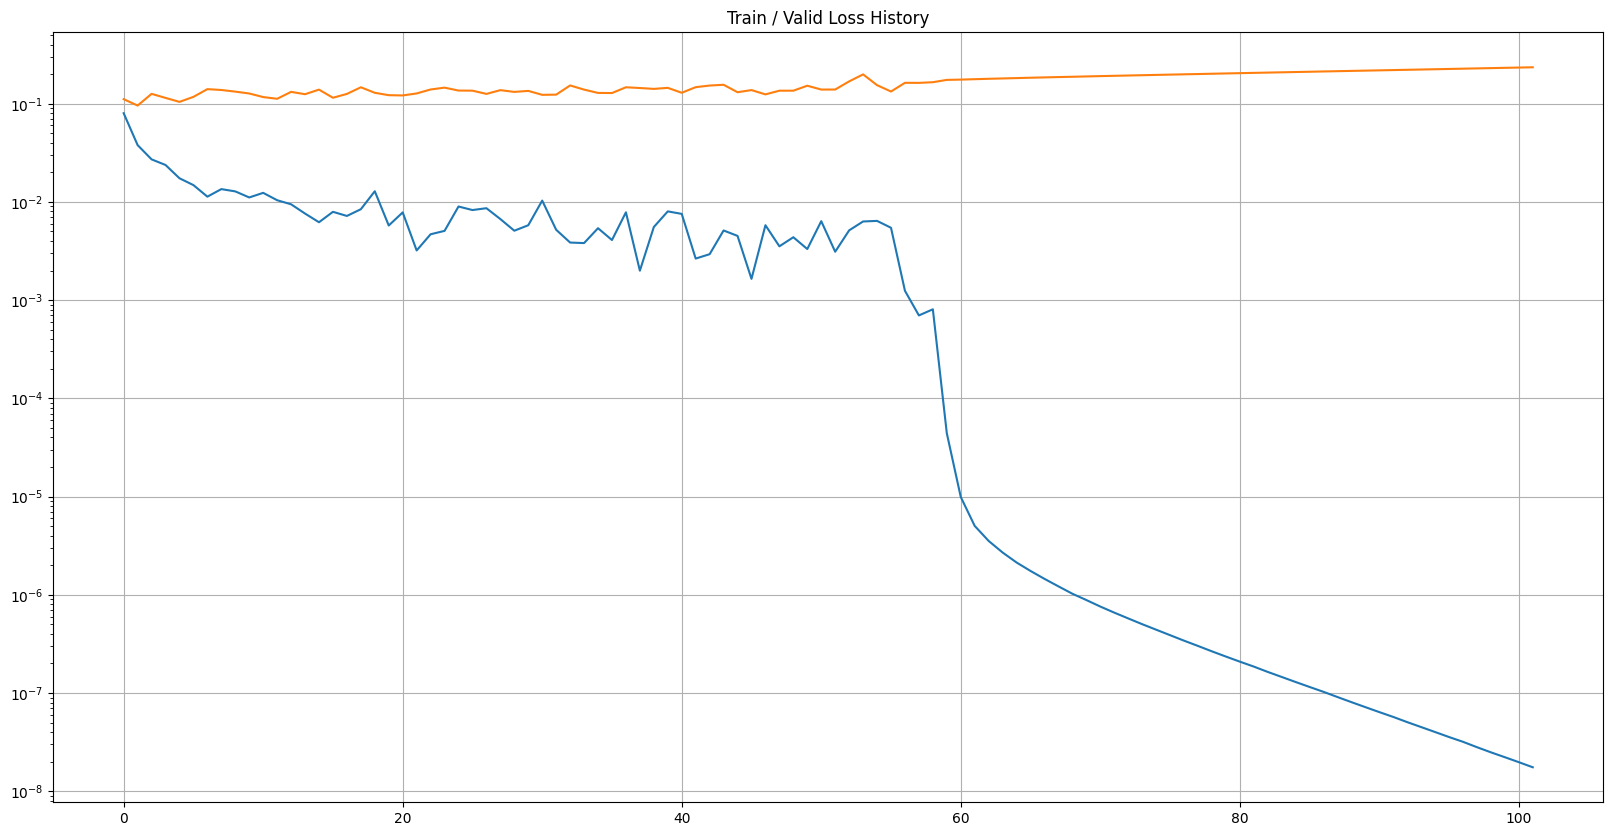

In [95]:
# 손실곡선 확인

plot_from = 0

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

# 14. 정규화

## 정규화란?
- 오버피팅을 늦추고 모델이 학습 데이터로부터 적절한 특징들을 학습하여 일반화 오차를 낮춰줄 수 있는 기법

### 정규화 종류
- 데이터를 통한 정규화
  - 데이터 증강
- 손실 함수를 통한 정규화
  - 가중치 감쇠 (오버피팅은 뉴런들의 가중치가 세다는 의미_학습데이터에 강하게 맞춰진 가중치)
- 신경망 계층을 통한 정규화
  - 드롭아웃
  - 배치 정규화
  - 계층 정규화
- 학습/추론 방식을 통한 정규화
  - 학습 조기 종료
  - 배깅 & 앙상블